In [2]:
import numpy as np
import pywt as pw
import matplotlib.pyplot as plt

import os
import shutil
import wfdb # to read heartbeat files

from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz, decimate, get_window
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show

# Filter Generation - Golden Model

Demo inspiration from https://scipy-cookbook.readthedocs.io/items/FIRFilter.html

In [ ]:
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
input_signal = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)

In [ ]:
#------------------------------------------------
# Function to create a FIR filter.
#------------------------------------------------

# NOTE: ripple_db and width should be specified if using Kaiser window
# TODO: Add Kaiser filter back in
def generate_filter(N, sample_rate, cutoff_hz, ripple_db, width, lowpass=True):
    # The Nyquist rate of the signal.
    nyq_rate = sample_rate / 2.0
    
    # Compute the order and Kaiser parameter for the FIR filter.
    # Note: cannot generate highpass filter using firwin if N is even; N must be odd
    # N, beta = kaiserord(ripple_db, width)
    
    if lowpass:
        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        #lowpass_taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=True)
        # TODO: Haar window not supported by firwin, find a workaround to be consistent with medium article
        lowpass_taps = firwin(N, cutoff_hz/nyq_rate, pass_zero=True)
        #print("Creating ", N, "-tap lowpass filter, cutoff freq: ", cutoff_hz, "\n taps:", lowpass_taps)
        return lowpass_taps
    else:
        # Use firwin with a Kaiser window to create a highpass FIR filter.
        #highpass_taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
        highpass_taps = firwin(N, cutoff_hz/nyq_rate, pass_zero=False)
        #print("Creating ", N, "-tap highpass filter, cutoff freq: ", cutoff_hz, "\n taps:", highpass_taps)
        return highpass_taps

In [ ]:
#------------------------------------------------
# Choose the filter parameters.
#------------------------------------------------

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
nyq_rate = sample_rate / 2.0
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

N = 75

# The cutoff frequency of the filter.
cutoff_hz = 49.0

In [ ]:
#------------------------------------------------
# Generate the lowpass and highpass filters.
#------------------------------------------------

lp_taps = generate_filter(N, sample_rate, cutoff_hz, ripple_db, width, lowpass=True)
hp_taps = generate_filter(N, sample_rate, cutoff_hz, ripple_db, width, lowpass=False)

In [ ]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

# lowpass filter
figure(1)
plot(lp_taps, 'bo-', linewidth=2)
title('Lowpass Filter Coefficients (%d taps)' % N)
grid(True)

# highpass filter
figure(2)
plot(hp_taps, 'bo-', linewidth=2)
title('Highpass Filter Coefficients (%d taps)' % N)
grid(True)

In [ ]:
#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

# Lowpass filter
figure(1)
clf()
w, h = freqz(lp_taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#######################################################################3
# Highpass filter
figure(2)
clf()
w, h = freqz(hp_taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

In [ ]:
#------------------------------------------------
# Function to apply FIR filters to input_signal.
#------------------------------------------------

# NOTE: filter length will be a parameter in scala
def filter_signal(taps, signal):
    # Use lfilter to filter input_signal with the FIR filters.
    return lfilter(taps, 1.0, signal)

def apply_lowpass_filter(signal, lp_taps=lp_taps):
    return(filter_signal(lp_taps, signal))

def apply_highpass_filter(signal, hp_taps=hp_taps):
    return(filter_signal(hp_taps, signal))

In [ ]:
#------------------------------------------------
# Apply filters to input signal.
#------------------------------------------------
LP_filtered_input_signal = apply_lowpass_filter(input_signal)
HP_filtered_input_signal = apply_highpass_filter(input_signal)

print(LP_filtered_input_signal)
print(HP_filtered_input_signal)

print(len(LP_filtered_input_signal))
print(len(HP_filtered_input_signal))


In [ ]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate


# Lowpass filter
figure(1)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, LP_filtered_input_signal, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, LP_filtered_input_signal[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)
"""

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, LP_filtered_input_signal, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, LP_filtered_input_signal[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

"""
# Highpass filter
figure(2)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, HP_filtered_input_signal, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, HP_filtered_input_signal[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()


## Naive Decimation
Simply remove every other element from the list

In [ ]:
my_list = [1, 2, 3, 4, 5]
print(my_list[1::2])

In [ ]:
LP_filtered_downsampled_input_signal = LP_filtered_input_signal[1::2]
HP_filtered_downsampled_input_signal = HP_filtered_input_signal[1::2]

## Low-pass filter decimate 
Apply an anti-alias filter before downsampling to avoid aliasing of information

In [ ]:
LP_filtered_downsampled_input_signal = decimate(LP_filtered_input_signal, 2, ftype='fir', axis=-1, zero_phase=True)

In [ ]:
def decimate_signal(signal, decimation_factor=2, naive=True):
    if naive:
        return signal[1::decimation_factor]
    else:
        return decimate(signal, decimation_factor, ftype='fir', axis=-1, zero_phase=True)

In [ ]:
#------------------------------------------------
# Decimate the filtered signal.
#------------------------------------------------

LP_decimated_signal = decimate_signal(LP_filtered_input_signal, decimation_factor=2, naive=True)
HP_decimated_signal = decimate_signal(HP_filtered_input_signal, decimation_factor=2, naive=True)

# TODO: Require that the signal length along the transformed axis be a multiple of 2**level (if not decimating).
# If this is not the case, the user should pad up to an appropriate size using a function such as numpy.pad.


# Combine filters and decimation

In [ ]:
# Function to perform single level of wavelet transform (highpass & lowpass filters, decimation)

def single_level_wavelet_transform(input_signal, num_taps, sample_rate, cutoff_hz, ripple_db, width, decimate=True, naive=True):
    #------------------------------------------------
    # Generate the lowpass and highpass filters.
    #------------------------------------------------

    lp_taps = generate_filter(N, sample_rate, cutoff_hz, ripple_db, width, lowpass=True)
    hp_taps = generate_filter(N, sample_rate, cutoff_hz, ripple_db, width, lowpass=False)

    #------------------------------------------------
    # Apply filters to input signal.
    #------------------------------------------------
    LP_filtered_input_signal = apply_lowpass_filter(input_signal)
    HP_filtered_input_signal = apply_highpass_filter(input_signal)

    #------------------------------------------------
    # Decimate the filtered signal.
    #------------------------------------------------
    if decimate:
        LP_decimated_signal = decimate_signal(LP_filtered_input_signal, decimation_factor=2, naive=True)
        HP_decimated_signal = decimate_signal(HP_filtered_input_signal, decimation_factor=2, naive=True)
        
        return (LP_decimated_signal, HP_decimated_signal) # be consistent with pywt: (cA1, cD1) where approximation coeffs are from LPF
    else: 
        return (LP_filtered_input_signal, HP_filtered_input_signal)

In [ ]:
# Test the function
coeffs = single_level_wavelet_transform(input_signal, N, sample_rate, cutoff_hz, ripple_db, width, decimate=False, naive=True)

In [ ]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

# Lowpass filter
figure(1)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, coeffs[0], 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, coeffs[0][N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)
"""

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, LP_filtered_input_signal, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, LP_filtered_input_signal[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

"""
# Highpass filter
figure(2)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, coeffs[1], 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, coeffs[1][N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

In [ ]:
def multi_level_wavelet_transform(input_signal, N, sample_rate, cutoff_hz, ripple_db, width, decimate=False, naive=True, num_levels=3):
    all_coeffs = []
    all_coeffs_empty = []
    for i in range(0, num_levels):
        coeffs = single_level_wavelet_transform(input_signal, N, sample_rate, cutoff_hz, ripple_db, width, decimate, naive)
        all_coeffs = [coeffs] + all_coeffs
        all_coeffs_empty = [(0,0)] + all_coeffs_empty
        print("Level: ", i)
        print("Coeffs list structure: ", all_coeffs_empty)
    return all_coeffs

In [ ]:
all_coeffs = multi_level_wavelet_transform(input_signal, N, sample_rate, cutoff_hz, ripple_db, width, decimate=False, naive=True, num_levels=3)
#print(all_coeffs)

In [ ]:
#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

# Lowpass filter
figure(1)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, all_coeffs[1][0], 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, all_coeffs[1][0][N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)
"""

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, LP_filtered_input_signal, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, LP_filtered_input_signal[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

"""
# Highpass filter
figure(2)
# Plot the original signal.
plot(t, input_signal)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, all_coeffs[1][0], 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, all_coeffs[1][1][N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

In [ ]:
w = pw.Wavelet('haar')
phi, psi, x = w.wavefun(level=20)
print(w)

fig, ax = plt.subplots()
ax.set_xlim(-0.02, 1.02)
ax.plot(x, psi)

### Heartbeat datasets:

MIT - http://physionet.org/physiobank/database/mitdb/
360 samples per second per channel with 11-bit resolution over a 10 mV range

To read the dataset using python, use the wfdb python library: https://github.com/MIT-LCP/wfdb-python

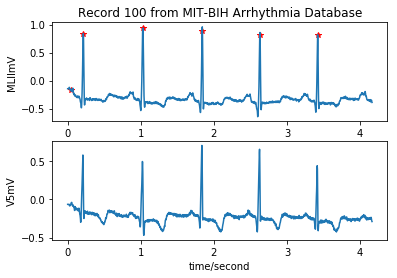

In [11]:
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord('./heartbeat_dataset/100', sampto = 1500)
annotation = wfdb.rdann('./heartbeat_dataset/100', 'atr', sampto = 1500)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')

heartbeat_sample_rate = 360

print(record)
